# PLV Model Prototype

In [51]:
# Install required libraries (uncomment if running in a fresh environment)
# !pip install requests pandas
# !pip install statsmodels

import requests
import pandas as pd
import json

## Fetch Data from Subgraph API

Send the GraphQL query to the subgraph API endpoint and fetch the response.

In [52]:
import requests
import pandas as pd
import json
from datetime import datetime

def date_to_unix(date_str):
    """Convert a date string in 'YYYY-MM-DD' format to a Unix timestamp."""
    dt = datetime.strptime(date_str, '%Y-%m-%d')
    return int(dt.timestamp())

def make_price_query(pool_address, start_ts, end_ts):
    """Create a GraphQL query string for fetching price, volume, and liquidity of a Uniswap V3 pool."""
    return f"""
    {{
      poolHourDatas(first: 1000, where: {{pool: \"{pool_address}\", periodStartUnix_gte: {start_ts}, periodStartUnix_lte: {end_ts}}}, orderBy: periodStartUnix, orderDirection: asc) {{
        periodStartUnix
        token0Price
        volumeUSD
        liquidity
      }}
    }}
    """

def fetch_pool_hourly_data(api_key, subgraph_id, pool_address, start_date, end_date):
    """
    Fetch hourly price (token0Price as 'price'), volumeUSD, liquidity, and datetimes for a Uniswap V3 pool from the subgraph.
    Dates should be in 'YYYY-MM-DD' format.
    Returns a pandas DataFrame with columns: periodStartUnix, price, volumeUSD, liquidity
    """
    start_ts = date_to_unix(start_date)
    end_ts = date_to_unix(end_date)
    all_data = []
    last_ts = start_ts
    while True:
        graphql_query = make_price_query(pool_address, last_ts, end_ts)
        payload = {
            "query": graphql_query,
            "operationName": "Subgraphs",
            "variables": {}
        }
        url = f"https://gateway.thegraph.com/api/subgraphs/id/{subgraph_id}"
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Query failed with status code {response.status_code}: {response.text}")
        result = response.json()
        hour_data = result['data']['poolHourDatas']
        if not hour_data:
            break
        all_data.extend(hour_data)
        if len(hour_data) < 1000:
            break
        # Update last_ts to one after the last returned timestamp to avoid overlap
        last_ts = int(hour_data[-1]['periodStartUnix']) + 1

    df = pd.DataFrame(all_data)
    if not df.empty:
        df['periodStartUnix'] = pd.to_datetime(df['periodStartUnix'], unit='s')
        df = df.rename(columns={"token0Price": "price"})
        df['price'] = pd.to_numeric(df['price'])
        df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])
        df['liquidity'] = pd.to_numeric(df['liquidity'])
    return df

# Example usage:
api_key = "d1762c97d76a973e078c5536742bd237"  # Replace with your API key
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"    # Replace with your subgraph id
pool_address = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"
start_date = "2024-06-01"
end_date = "2025-06-01"
df = fetch_pool_hourly_data(api_key, subgraph_id, pool_address, start_date, end_date)
df.head()
print(df.count())

liquidity          8125
periodStartUnix    8125
price              8125
volumeUSD          8125
dtype: int64


## Feature Engineering: Price Returns, Volatility, Moving Averages, and Time Features

In this section, we compute engineered features for the PLV model, including:
- Price returns (log and simple)
- Rolling volatility (e.g., 6-hour standard deviation)
- Moving averages (e.g., 6-hour, 24-hour)
- Time-based features (hour of day, day of week, month, season)

These features are useful for modeling and backtesting strategies on Uniswap V3 pool data.

In [53]:
import numpy as np
import pandas as pd

# Ensure 'datetime' column exists and is proper datetime
df['datetime'] = pd.to_datetime(df['periodStartUnix'], unit='s')

# Sort by datetime just in case
df = df.sort_values('datetime').reset_index(drop=True)

# Price returns (simple and log)
df['price_return'] = df['price'].pct_change()
df['log_return'] = np.log(df['price']).diff()

# Liquidity and volume percent changes
df['liquidity_return'] = df['liquidity'].pct_change()
df['volume_return'] = df['volumeUSD'].pct_change()

# Rolling volatility (6-hour window, assuming hourly data)
df['volatility_6h'] = df['log_return'].rolling(window=6).std()

# Moving averages
df['ma_6h'] = df['price'].rolling(window=6).mean()
df['ma_24h'] = df['price'].rolling(window=24).mean()

# Time-based features from 'datetime'
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
# Season: 0=winter, 1=spring, 2=summer, 3=fall
def get_season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3
df['season'] = df['month'].apply(get_season)

# Optionally drop 'periodStartUnix' if not needed
df = df.drop(columns=['periodStartUnix'])

df.head(100)

,liquidity,price,volumeUSD,datetime,price_return,log_return,liquidity_return,volume_return,volatility_6h,ma_6h,ma_24h,hour,day_of_week,month,season
0,980515581418284989,0.055902,6.862535e+05,2024-05-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4,5,1
1,980516376042817813,0.055781,1.681957e+06,2024-05-31 23:00:00,-0.002154,-0.002157,8.104150e-07,1.450927,NaN,NaN,NaN,23,4,5,1
2,1011394361255515088,0.055739,6.033926e+05,2024-06-01 00:00:00,-0.000765,-0.000765,3.149155e-02,-0.641256,NaN,NaN,NaN,0,5,6,2
3,1011394361255515088,0.055739,0.000000e+00,2024-06-01 02:00:00,0.000000,0.000000,0.000000e+00,-1.000000,NaN,NaN,NaN,2,5,6,2
4,1011394008378098942,0.055739,0.000000e+00,2024-06-01 03:00:00,0.000000,0.000000,-3.489019e-07,NaN,NaN,NaN,NaN,3,5,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,984763001718238830,0.053541,0.000000e+00,2024-06-05 09:00:00,0.000000,0.000000,-6.041020e-05,-1.000000,0.001984,0.053587,0.054023,9,2,6,2
96,984763038910752903,0.053541,0.000000e+00,2024-06-05 10:00:00,0.000000,0.000000,3.776798e-08,NaN,0.001985,0.053541,0.053980,10,2,6,2
97,984387100097426626,0.053513,6.474778e+05,2024-06-05 11:00:00,-0.000524,-0.000524,-3.817556e-04,inf,0.001570,0.053520,0.053935,11,2,6,2
98,983795519746468556,0.053697,2.781931e+06,2024-06-05 12:00:00,0.003441,0.003435,-6.009631e-04,3.296566,0.001438,0.053559,0.053898,12,2,6,2


In [54]:
# Remove outliers from returns using the IQR method
def remove_outliers_iqr(series, k=3.0):
    q_01 = series.quantile(0.1)
    q_90 = series.quantile(0.9)
    iqr = q_90 - q_01
    lower = q_01 - k * iqr
    upper = q_90 + k * iqr
    return series.where((series >= lower) & (series <= upper))

for col in ['price_return', 'liquidity_return', 'volume_return', 'log_return']:
    if col in df.columns:
        df[col] = remove_outliers_iqr(df[col])

## Analytical Plots: Feature Exploration

Let's visualize the main features and their relationships to better understand the data and engineered features. We'll plot time series, histograms, and scatter plots for key variables.

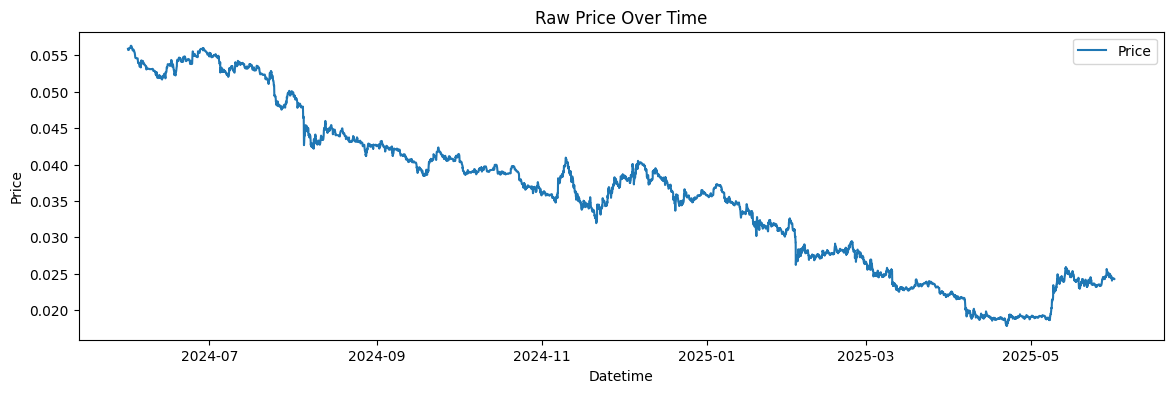

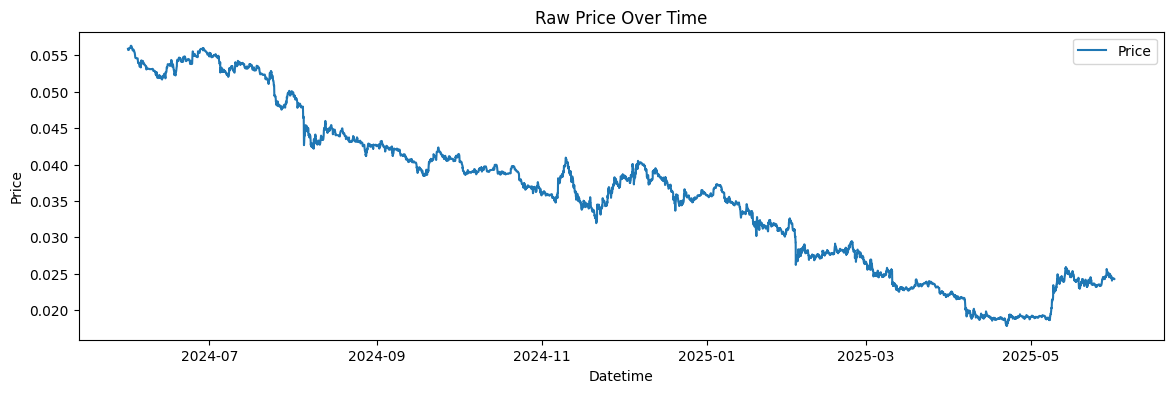

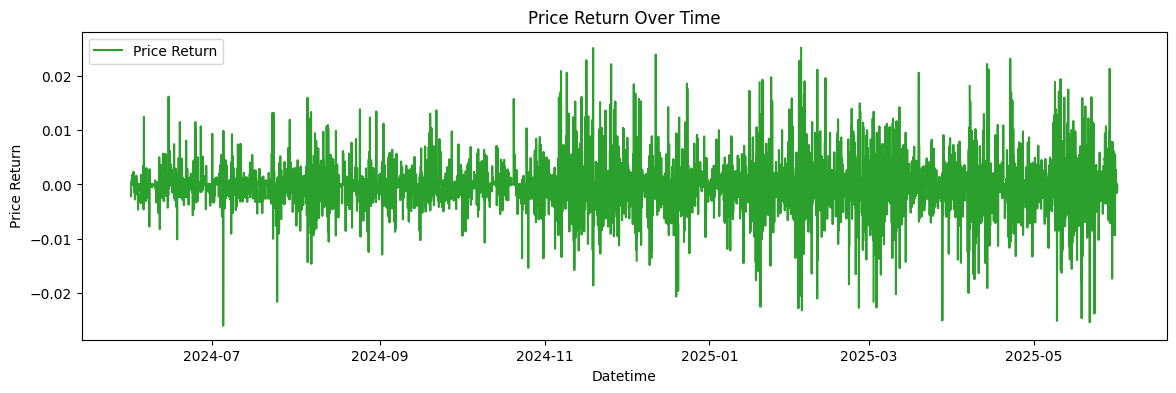

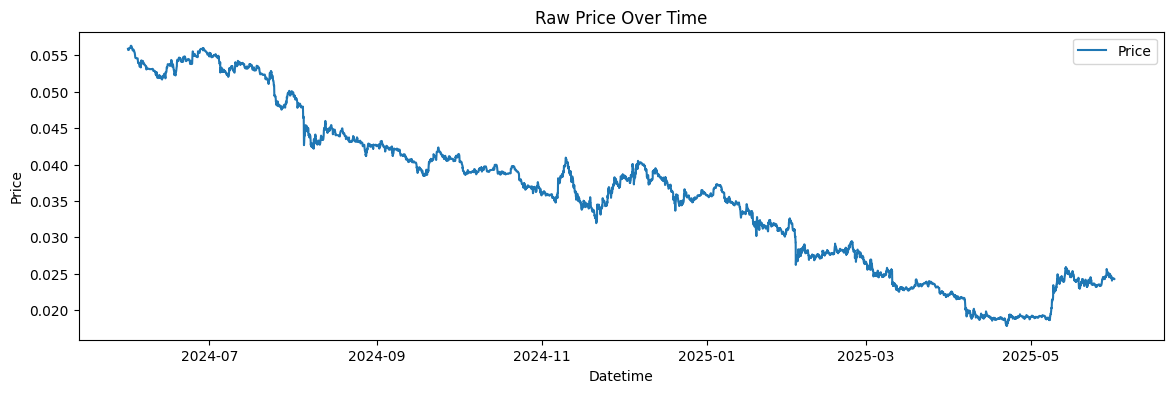

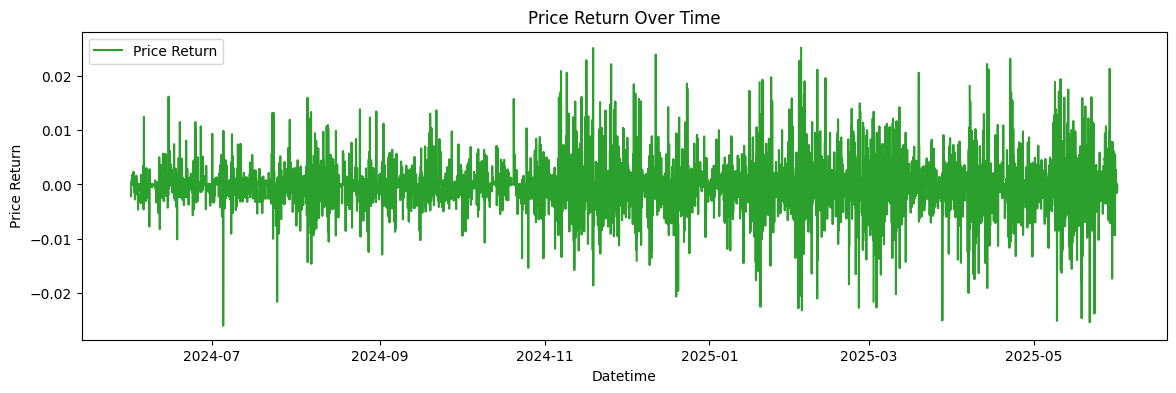

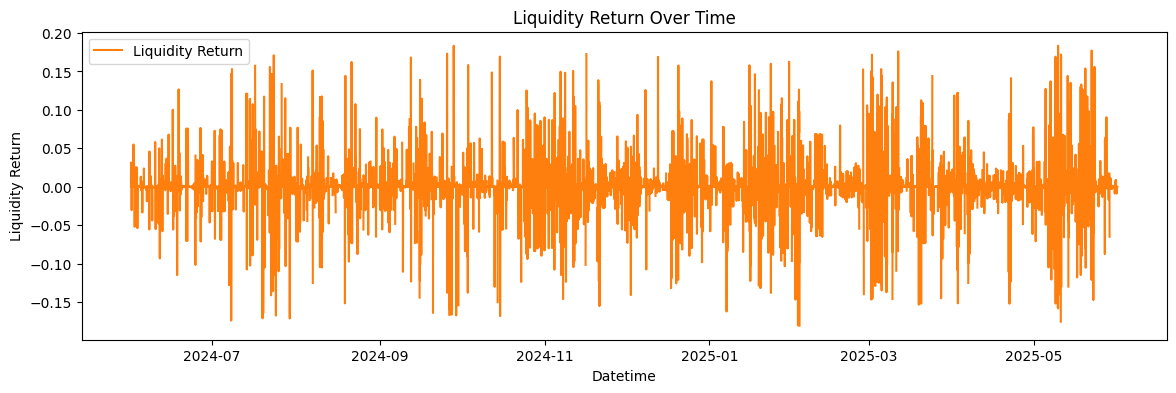

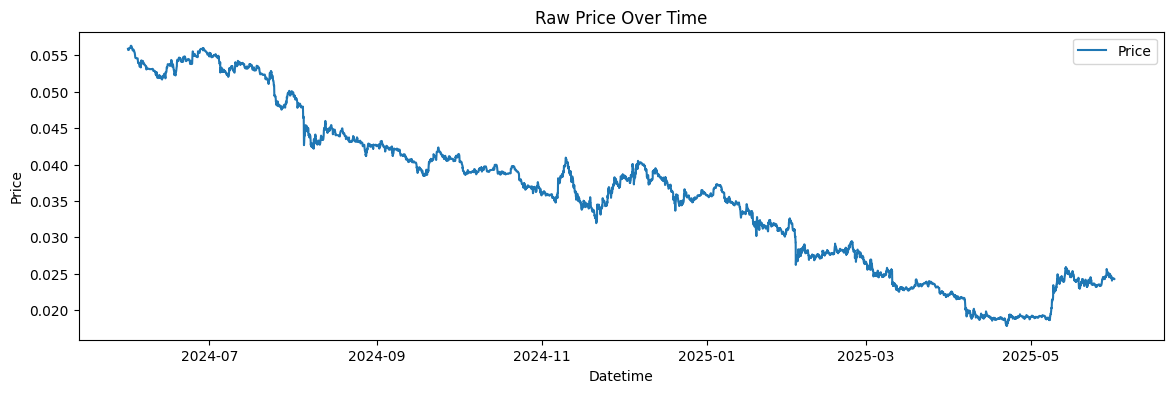

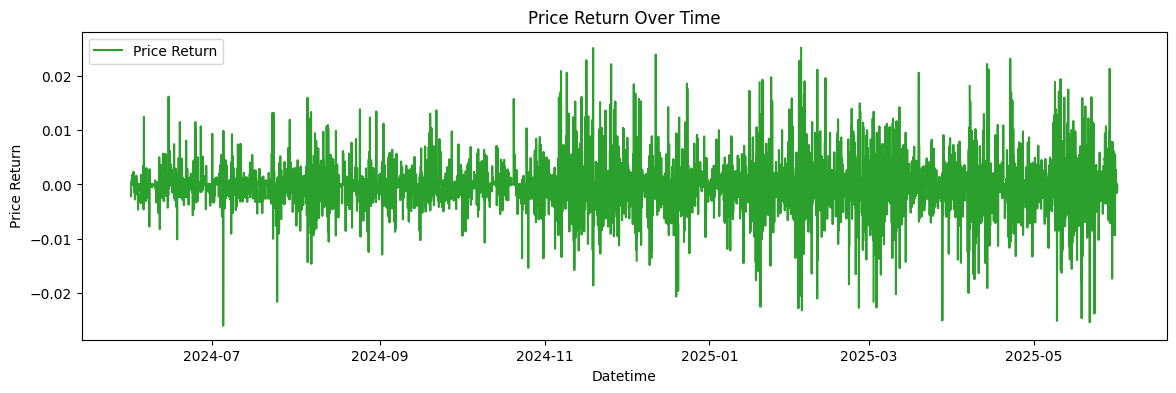

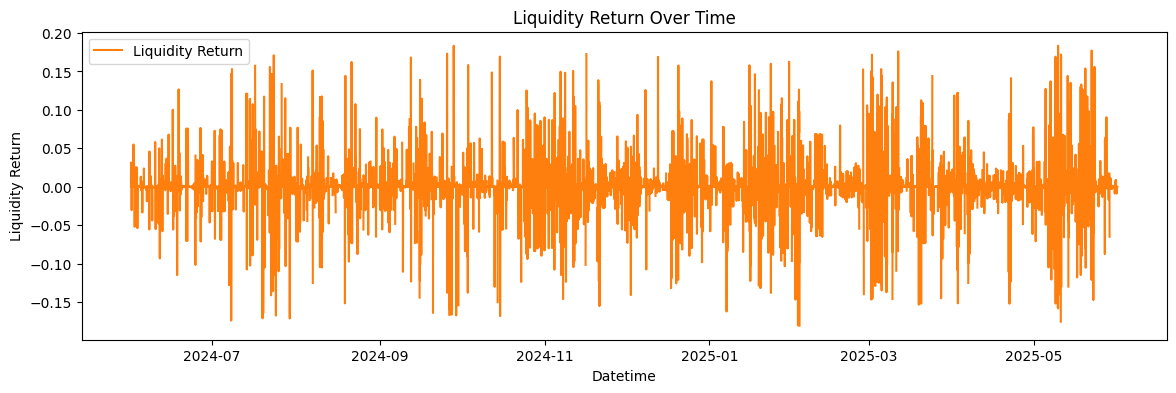

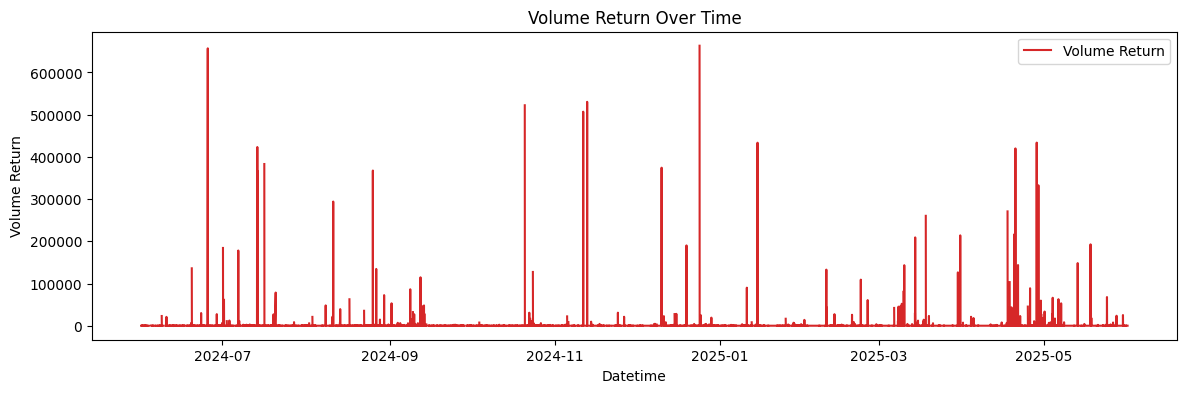

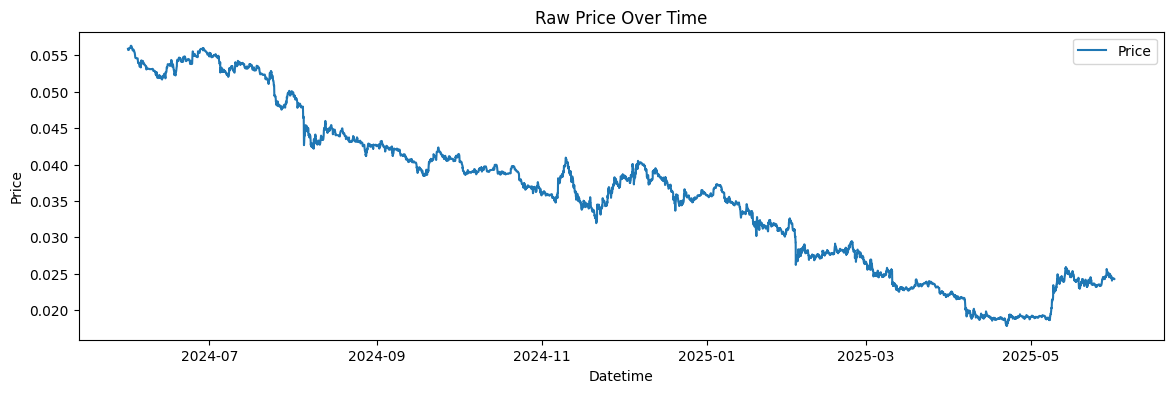

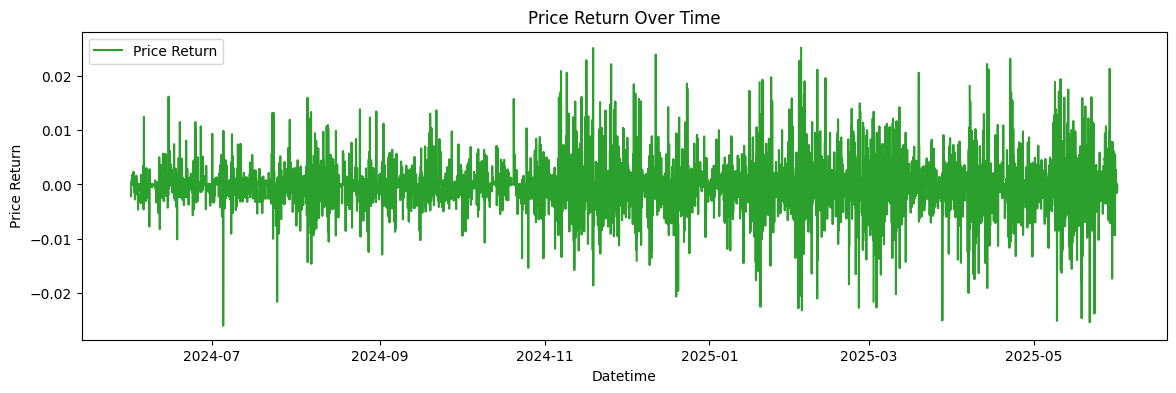

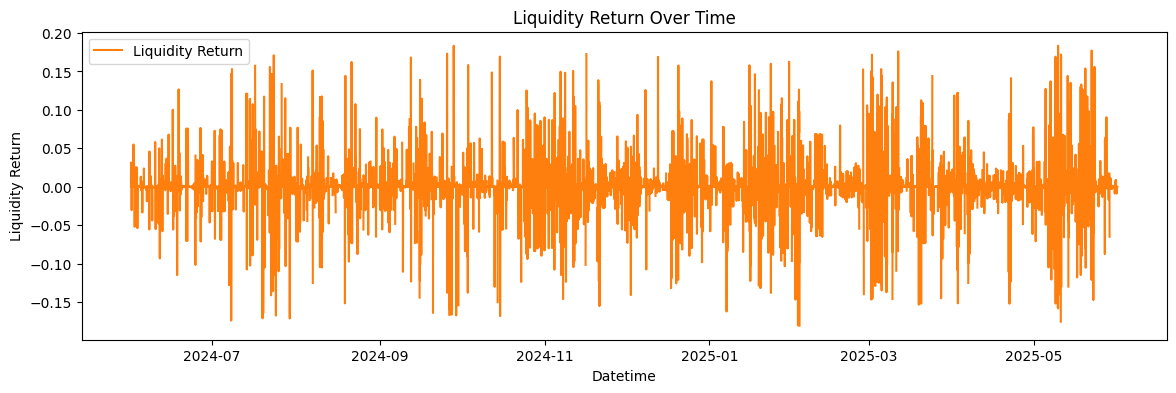

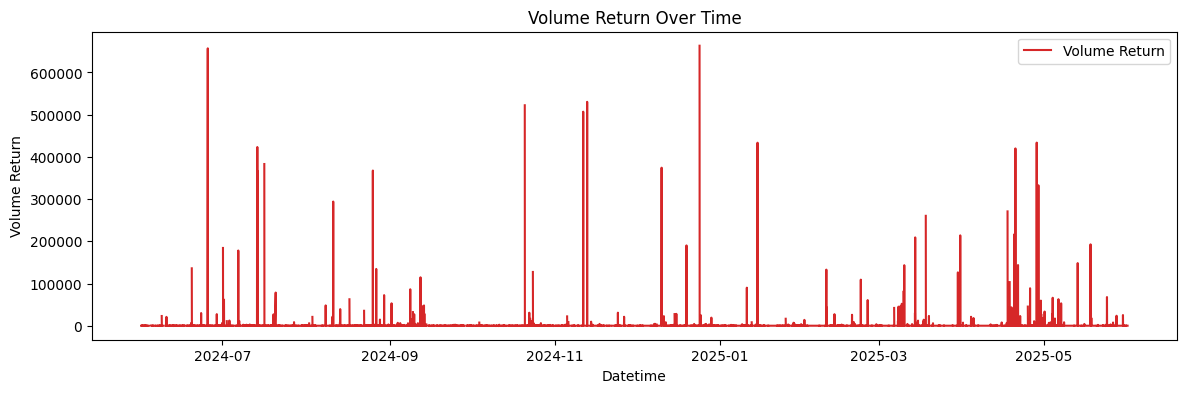

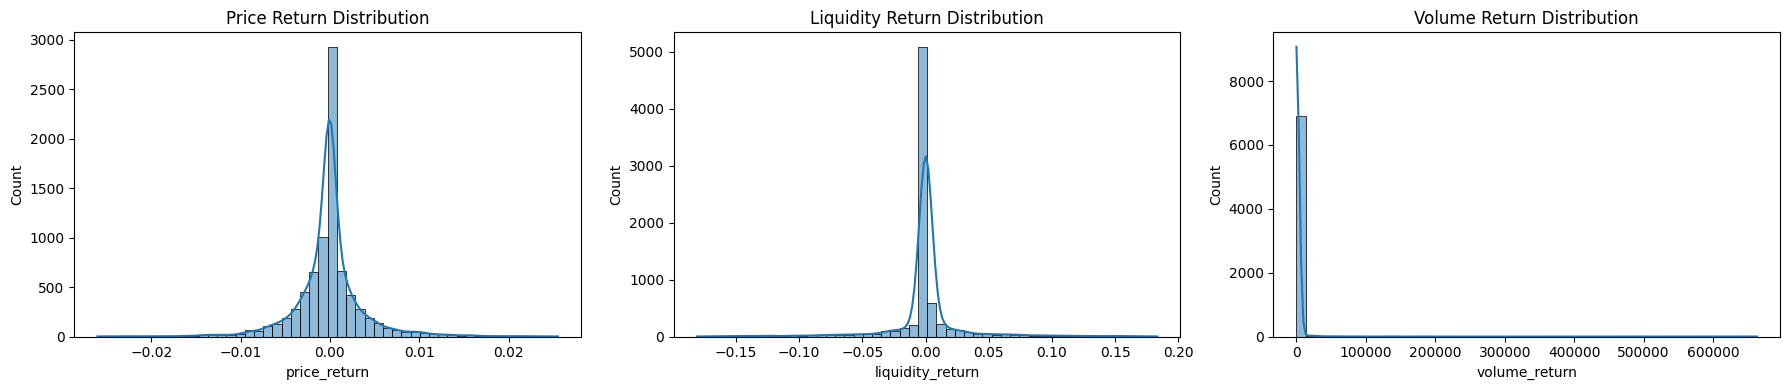

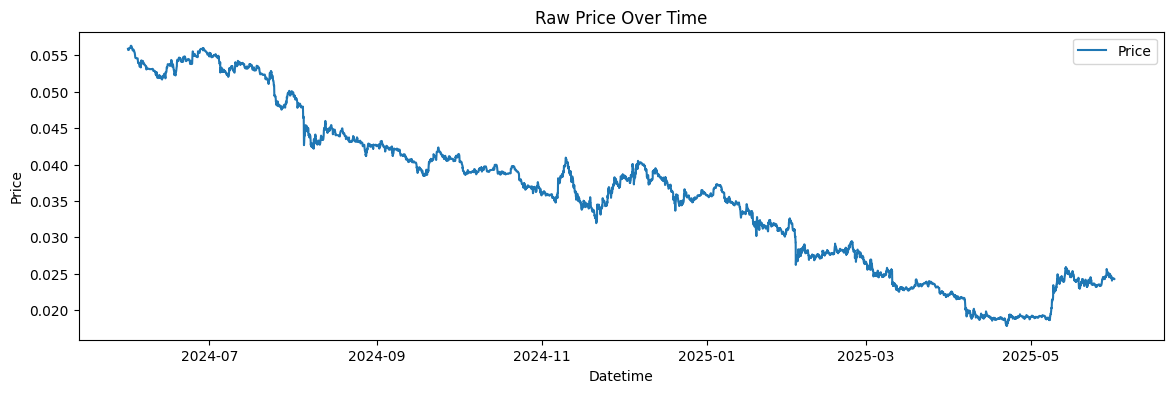

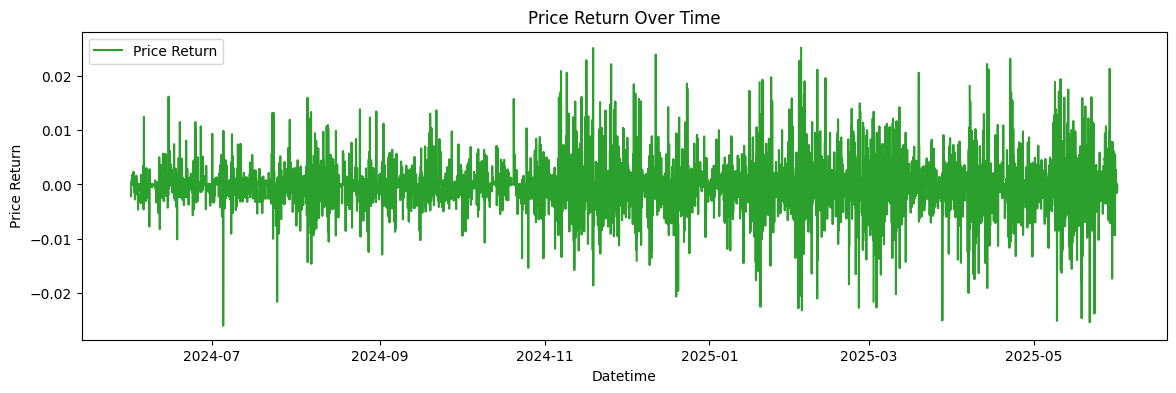

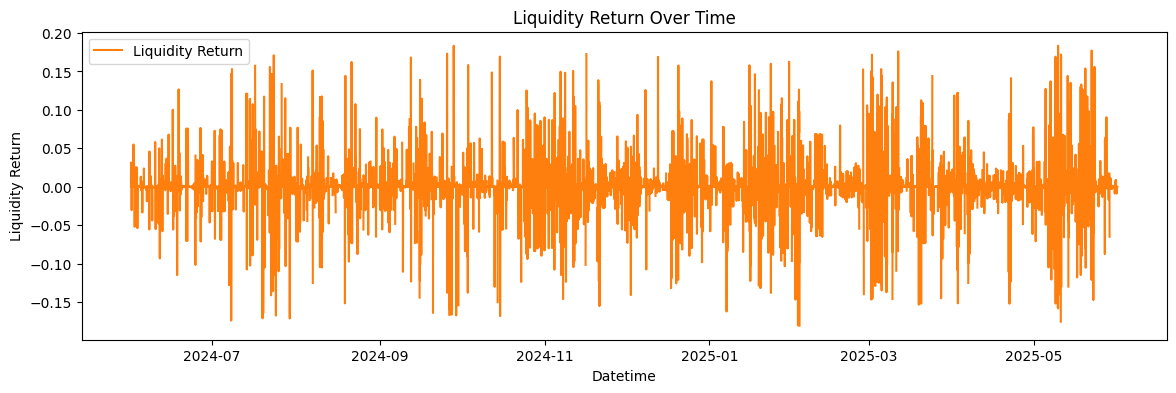

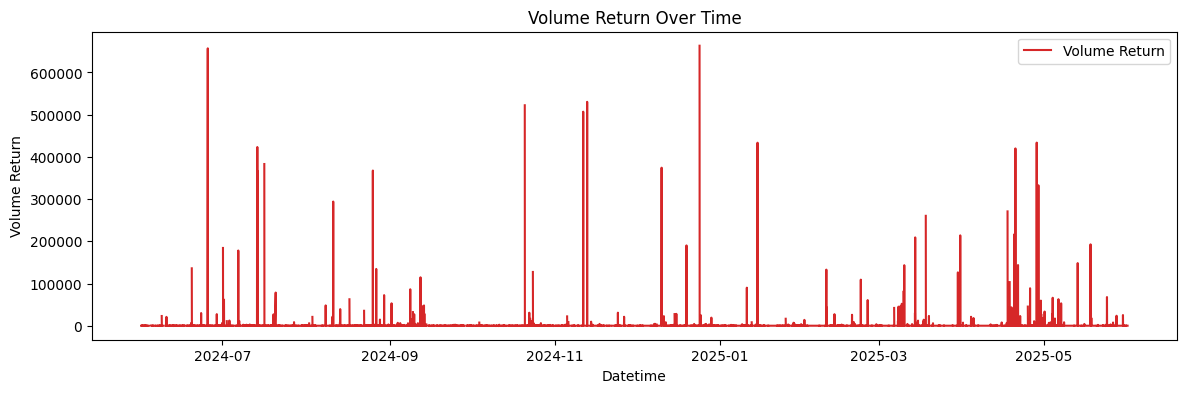

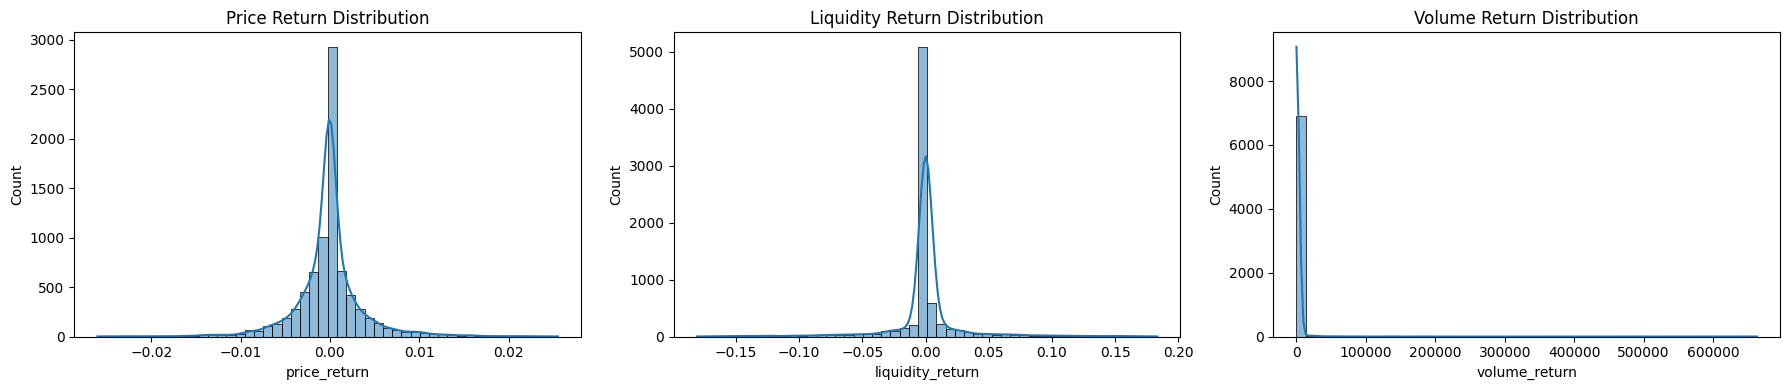

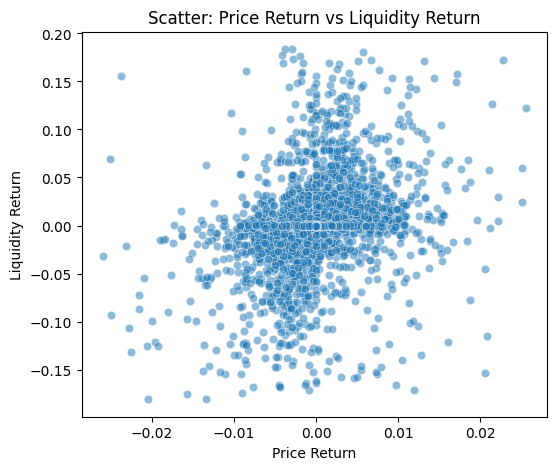

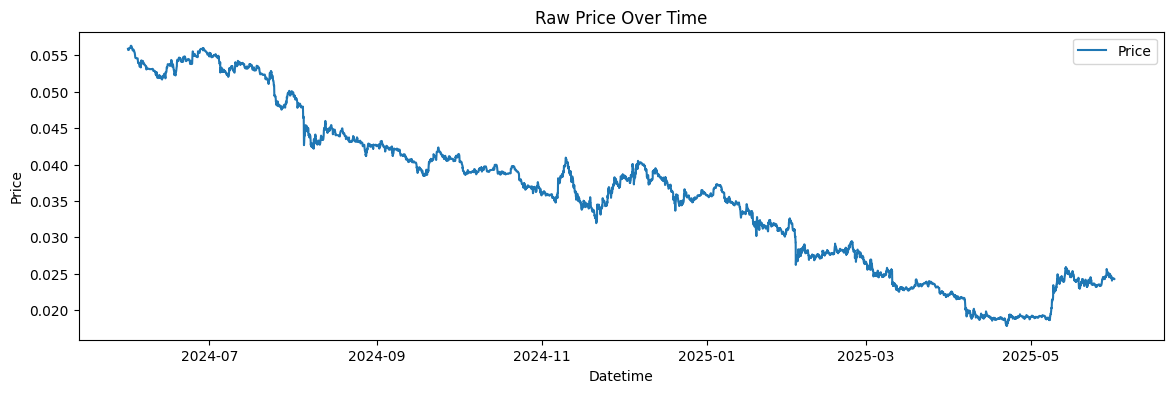

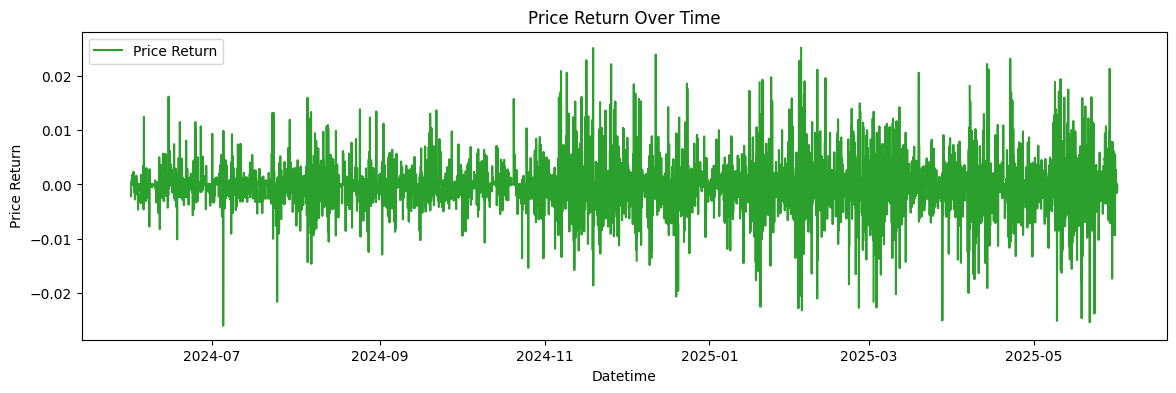

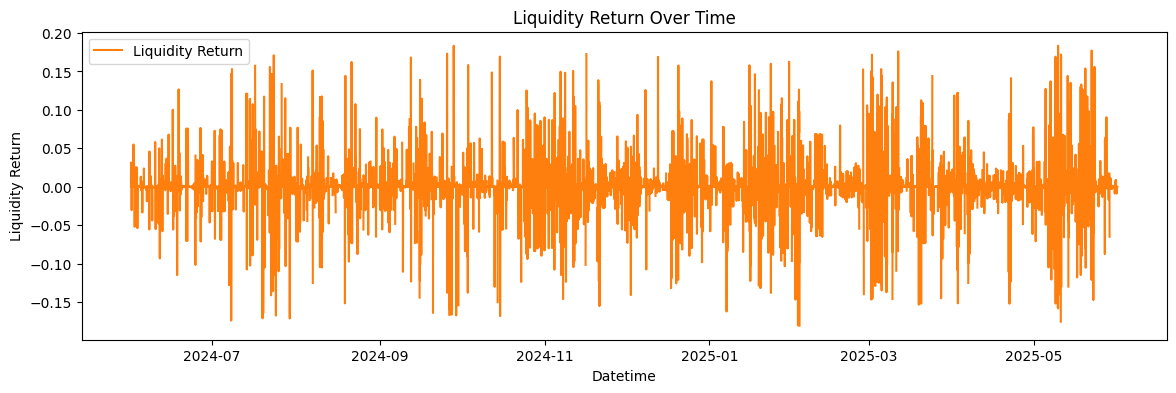

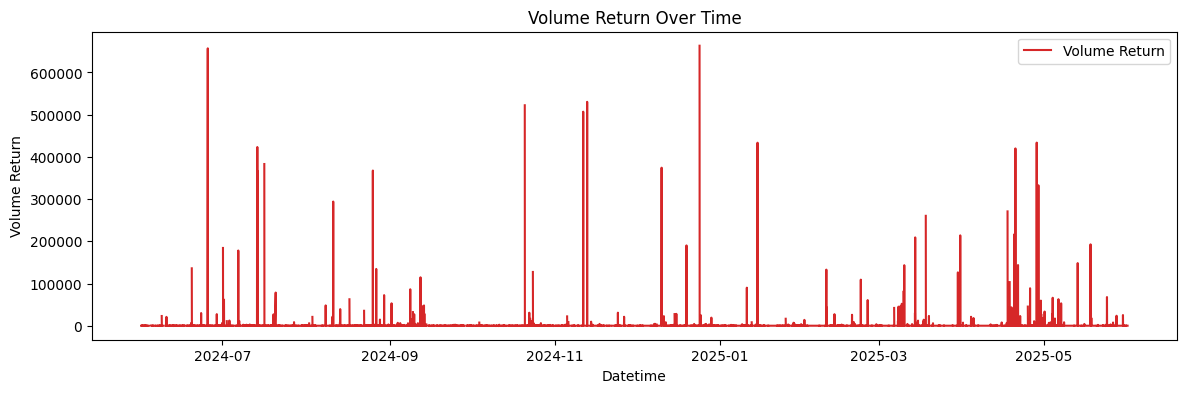

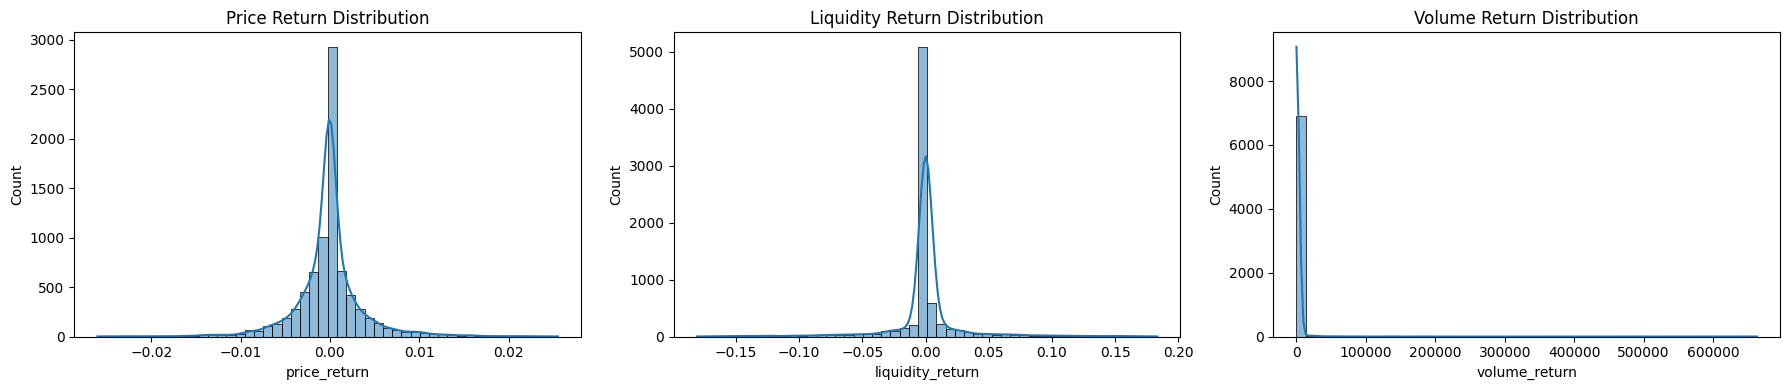

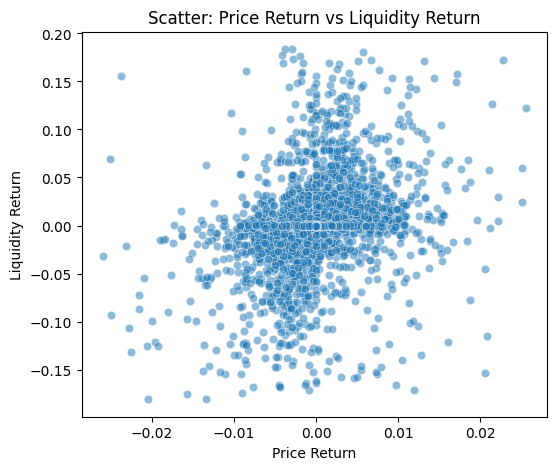

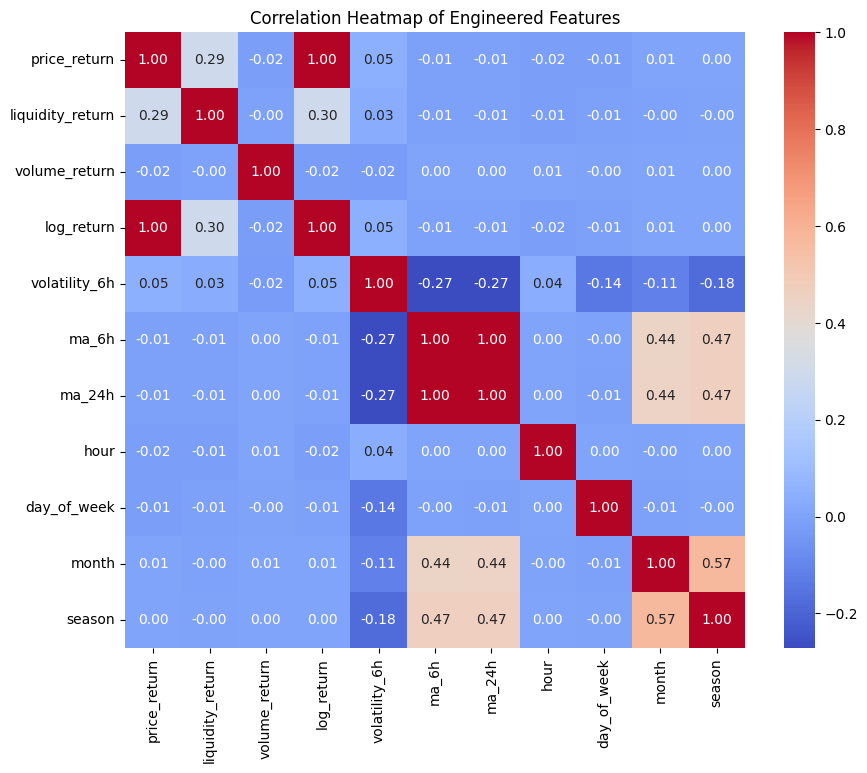

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot raw price over time
plt.figure(figsize=(14, 4))
plt.plot(df['datetime'], df['price'], label='Price', color='tab:blue')
plt.title('Raw Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot price return over time
plt.figure(figsize=(14, 4))
plt.plot(df['datetime'], df['price_return'], label='Price Return', color='tab:green')
plt.title('Price Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price Return')
plt.legend()
plt.show()

# Plot liquidity return over time
plt.figure(figsize=(14, 4))
plt.plot(df['datetime'], df['liquidity_return'], label='Liquidity Return', color='tab:orange')
plt.title('Liquidity Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Liquidity Return')
plt.legend()
plt.show()

# Plot volume return over time
plt.figure(figsize=(14, 4))
plt.plot(df['datetime'], df['volume_return'], label='Volume Return', color='tab:red')
plt.title('Volume Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Volume Return')
plt.legend()
plt.show()

# Histograms of returns
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['price_return'].dropna(), bins=50, ax=axs[0], kde=True)
axs[0].set_title('Price Return Distribution')
sns.histplot(df['liquidity_return'].dropna(), bins=50, ax=axs[1], kde=True)
axs[1].set_title('Liquidity Return Distribution')
sns.histplot(df['volume_return'].dropna(), bins=50, ax=axs[2], kde=True)
axs[2].set_title('Volume Return Distribution')
plt.tight_layout()
plt.show()

# Scatter plot: price_return vs liquidity_return
plt.figure(figsize=(6, 5))
sns.scatterplot(x=df['price_return'], y=df['liquidity_return'], alpha=0.5)
plt.title('Scatter: Price Return vs Liquidity Return')
plt.xlabel('Price Return')
plt.ylabel('Liquidity Return')
plt.show()

# Correlation heatmap of engineered features
engineered_cols = [
    'price_return', 'liquidity_return', 'volume_return',
    'log_return', 'volatility_6h', 'ma_6h', 'ma_24h',
    'hour', 'day_of_week', 'month', 'season'
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[engineered_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

## Stationarity Check

To ensure robust modeling, we check the stationarity of the price, price returns, and log returns using the Augmented Dickey-Fuller (ADF) test. Stationary series are required for many time series models.

In [56]:
from statsmodels.tsa.stattools import adfuller

# Helper function for ADF test
def adf_test(series, name):
    clean_series = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean_series) < 10:
        print(f"Not enough valid data for {name} to run ADF test.")
        return
    result = adfuller(clean_series)
    print(f"ADF Statistic for {name}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4g}")
    for key, value in result[4].items():
        print(f"    Critical Value {key}: {value:.4f}")
    print("Stationary" if result[1] < 0.05 else "Not stationary", "\n")
print("--- Stationarity Check ---")
adf_test(df['price'], 'price')
adf_test(df['price_return'], 'price_return')
adf_test(df['log_return'], 'log_return')
adf_test(df['liquidity_return'], 'liquidity_return')
adf_test(df['volume_return'], 'volume_return')

--- Stationarity Check ---
ADF Statistic for price: -1.5745
p-value: 0.4964
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Not stationary 

ADF Statistic for price: -1.5745
p-value: 0.4964
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Not stationary 

ADF Statistic for price_return: -14.5944
p-value: 4.264e-27
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 

ADF Statistic for price_return: -14.5944
p-value: 4.264e-27
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 

ADF Statistic for log_return: -14.6071
p-value: 4.078e-27
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 

ADF Statistic for log_return: -14.6071
p-value: 4.078e-27
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
St

## Benchmark Model and Evaluation Functions

We start with a naive benchmark model that predicts the next value as the current value (a persistence or "random walk" model). We also define evaluation functions (e.g., MAE, RMSE, MAPE) to assess model performance. These functions can be reused for more sophisticated models later.

In [57]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def naive_predict(series):
    """Naive model: predicts next value as the current value (persistence)."""
    # Shift series by 1 to get prediction for t+1 at time t
    return series.shift(1)

def evaluate_predictions(y_true, y_pred):
    """Compute MAE, RMSE, and MAPE for predictions."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Liquidity Return"):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index, y_true, label="Actual", color="tab:blue")
    plt.plot(y_true.index, y_pred, label="Predicted", color="tab:orange")
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Liquidity Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: Benchmark for price prediction
y_true = df['liquidity_return'].iloc[1:]  # true values from t=1
naive_pred = naive_predict(df['liquidity_return']).iloc[1:]  # predictions for t=1 onward
results = evaluate_predictions(y_true, naive_pred)
print("Naive benchmark results for liquidity_return:", results)

Naive benchmark results for liquidity_return: {'MAE': 0.021124929984514124, 'RMSE': np.float64(0.04445238110992005), 'MAPE': nan}


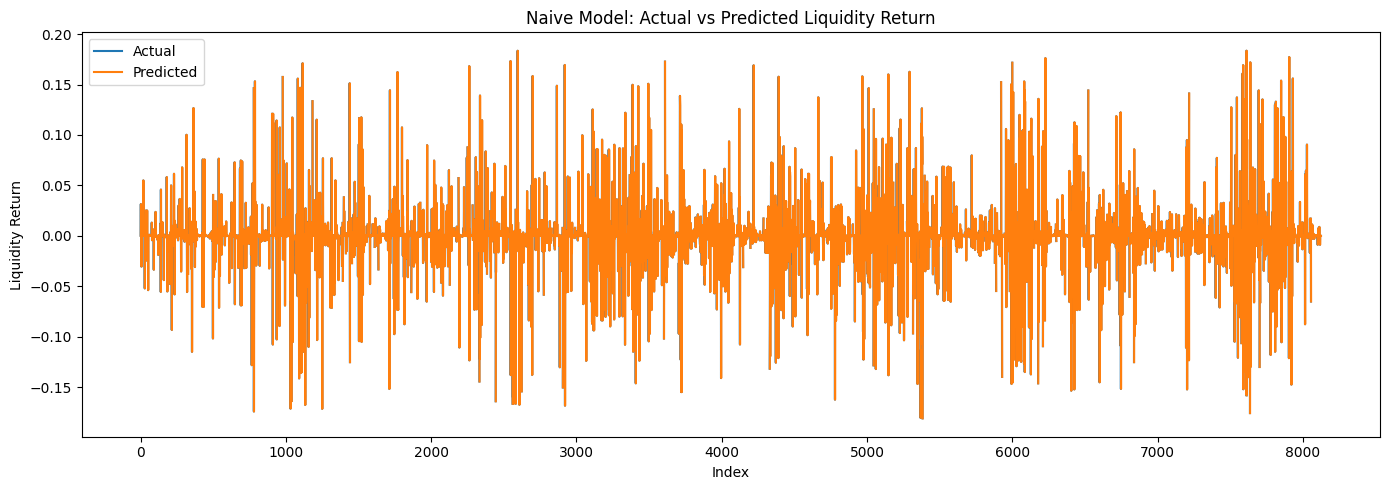

In [58]:
# Plot for Naive Benchmark Model
plot_actual_vs_predicted(y_true, naive_pred, title="Naive Model: Actual vs Predicted Liquidity Return")

## Simple Linear Regression: Predicting Liquidity Return from Lagged Price and Liqudity Returns 

We now fit a linear regression model to predict the next-step liquidity return using past price and liqudity returns. 

In [59]:
from sklearn.linear_model import LinearRegression
# Number of lags to include
n_lags = 3

# Ensure 'liquidity_return_next' exists
if 'liquidity_return_next' not in df.columns:
    df['liquidity_return_next'] = df['liquidity_return'].shift(-1)

# Create lagged features for price_return and liquidity_return
for lag in range(1, n_lags + 1):
    df[f'price_return_lag{lag}'] = df['price_return'].shift(lag)
    df[f'liquidity_return_lag{lag}'] = df['liquidity_return'].shift(lag)

# Update feature list to include lags
lagged_features = [f'price_return_lag{lag}' for lag in range(1, n_lags + 1)] + \
                  [f'liquidity_return_lag{lag}' for lag in range(1, n_lags + 1)]

X = df[lagged_features]
y = df['liquidity_return_next']

# Drop rows with NaNs in X or y
mask = X.notnull().all(axis=1) & y.notnull()
X_clean = X[mask]
y_clean = y[mask]

# Chronological train/test split (e.g., 80% train, 20% test)
split_idx = int(len(X_clean) * 0.8)
X_train, X_test = X_clean.iloc[:split_idx], X_clean.iloc[split_idx:]
y_train, y_test = y_clean.iloc[:split_idx], y_clean.iloc[split_idx:]

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
results = evaluate_predictions(y_test, y_pred)
print("Linear regression with lags results for liquidity_return_next:", results)

# Show coefficients for interpretability
coef_table = pd.DataFrame({'feature': lagged_features, 'coefficient': lr.coef_})
print(coef_table)

Linear regression with lags results for liquidity_return_next: {'MAE': 0.012224766994803765, 'RMSE': np.float64(0.02861960412630444), 'MAPE': nan}
                 feature  coefficient
0      price_return_lag1     0.273628
1      price_return_lag2     0.056511
2      price_return_lag3     0.125039
3  liquidity_return_lag1    -0.116488
4  liquidity_return_lag2    -0.040620
5  liquidity_return_lag3    -0.050093


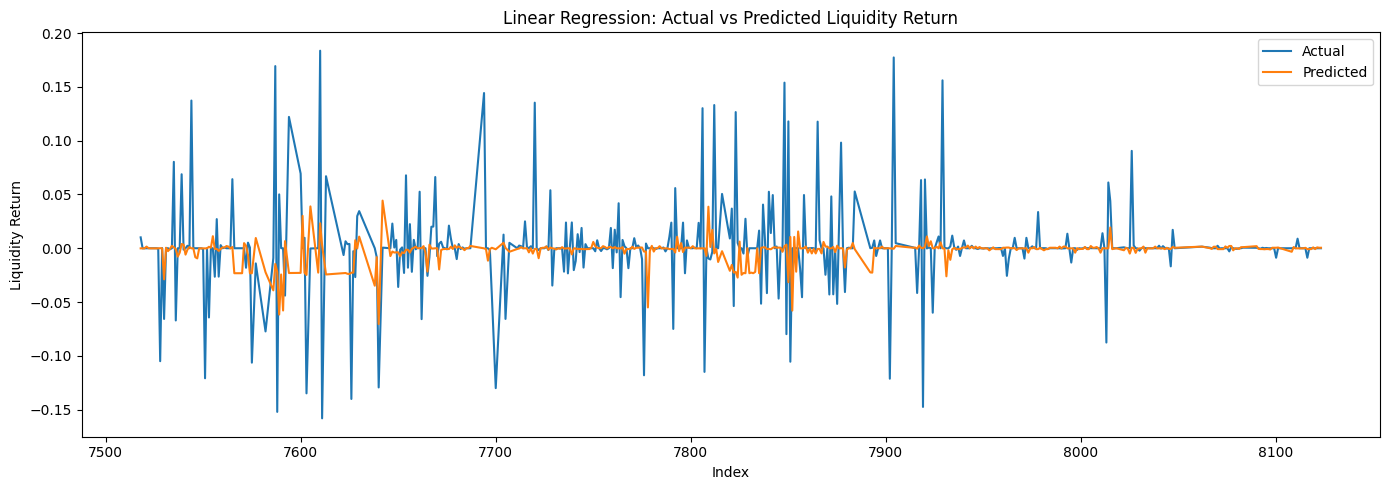

In [70]:
# Plot for Linear Regression Model
plot_actual_vs_predicted(y_test[-500:], y_pred[-500:], title="Linear Regression: Actual vs Predicted Liquidity Return")

## Random Forest Regression: Predicting Liquidity Return with Lags and Engineered Features

We now fit a random forest regression model to predict the next-step liquidity return using lagged values and selected engineered features. This non-linear model can capture more complex relationships than linear regression.

In [61]:
from sklearn.ensemble import RandomForestRegressor

# Use the same lagged_features and target as before
engineered_features = ["volatility_6h", "ma_6h", "ma_24h", "hour", 
                       "day_of_week", "month", "season"]
features = lagged_features + engineered_features
X = df[features]
y = df['liquidity_return_next']

# Drop rows with NaNs in X or y
mask = X.notnull().all(axis=1) & y.notnull()
X_clean = X[mask]
y_clean = y[mask]

# Chronological train/test split (e.g., 80% train, 20% test)
split_idx = int(len(X_clean) * 0.8)
X_train, X_test = X_clean.iloc[:split_idx], X_clean.iloc[split_idx:]
y_train, y_test = y_clean.iloc[:split_idx], y_clean.iloc[split_idx:]

# Fit random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
results = evaluate_predictions(y_test, y_pred)
print("Random forest results for liquidity_return_next:", results)

# Show feature importances
importances = rf.feature_importances_
importance_table = pd.DataFrame({'feature': features, 'importance': importances})
importance_table = importance_table.sort_values('importance', ascending=False)
print(importance_table)

Random forest results for liquidity_return_next: {'MAE': 0.018198894079070438, 'RMSE': np.float64(0.03255582249420292), 'MAPE': nan}
                  feature  importance
3   liquidity_return_lag1    0.120129
4   liquidity_return_lag2    0.114143
6           volatility_6h    0.108383
5   liquidity_return_lag3    0.106595
1       price_return_lag2    0.104003
0       price_return_lag1    0.093171
2       price_return_lag3    0.091759
7                   ma_6h    0.064937
8                  ma_24h    0.064936
9                    hour    0.057473
10            day_of_week    0.035076
11                  month    0.027700
12                 season    0.011694


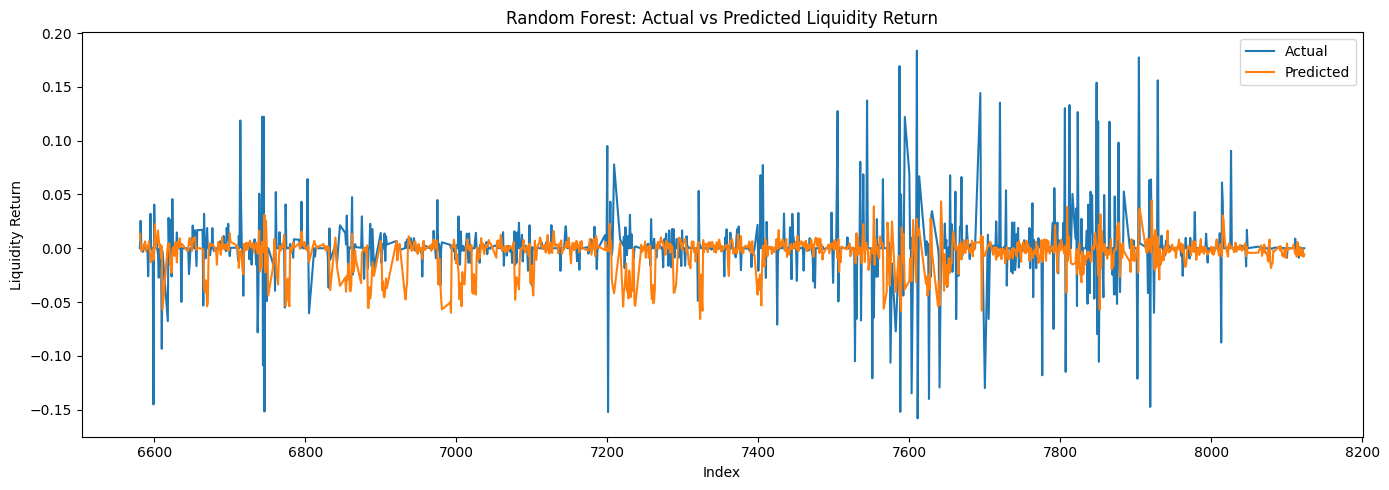

In [62]:
# Plot for Random Forest Model
plot_actual_vs_predicted(y_test, y_pred, title="Random Forest: Actual vs Predicted Liquidity Return")

## XGBoost Regression: Predicting Liquidity Return with Lags and Engineered Features

We now fit an XGBoost regression model to predict the next-step liquidity return using lagged values and selected engineered features. XGBoost is a powerful gradient boosting method that often yields strong results for tabular data.

In [63]:
import xgboost as xgb

# Use the same lagged_features and target as before
engineered_features = ["volatility_6h", "ma_6h", "ma_24h", "hour", 
                       "day_of_week", "month", "season"]
features = lagged_features + engineered_features
X = df[features]
y = df['liquidity_return_next']

# Drop rows with NaNs in X or y
mask = X.notnull().all(axis=1) & y.notnull()
X_clean = X[mask]
y_clean = y[mask]

# Chronological train/test split (e.g., 80% train, 20% test)
split_idx = int(len(X_clean) * 0.8)
X_train, X_test = X_clean.iloc[:split_idx], X_clean.iloc[split_idx:]
y_train, y_test = y_clean.iloc[:split_idx], y_clean.iloc[split_idx:]

# Fit XGBoost regressor
xgb_reg = xgb.XGBRegressor(n_estimators=5, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
results = evaluate_predictions(y_test, y_pred)
print("XGBoost results for liquidity_return_next:", results)

# Show feature importances
importances = xgb_reg.feature_importances_
importance_table = pd.DataFrame({'feature': features, 'importance': importances})
importance_table = importance_table.sort_values('importance', ascending=False)
print(importance_table)

XGBoost results for liquidity_return_next: {'MAE': 0.014755316530831132, 'RMSE': np.float64(0.03045254250960287), 'MAPE': nan}
                  feature  importance
3   liquidity_return_lag1    0.129172
1       price_return_lag2    0.119661
8                  ma_24h    0.084155
5   liquidity_return_lag3    0.081367
10            day_of_week    0.080716
2       price_return_lag3    0.080086
9                    hour    0.077215
6           volatility_6h    0.072971
4   liquidity_return_lag2    0.071131
7                   ma_6h    0.064806
12                 season    0.048884
11                  month    0.047427
0       price_return_lag1    0.042408


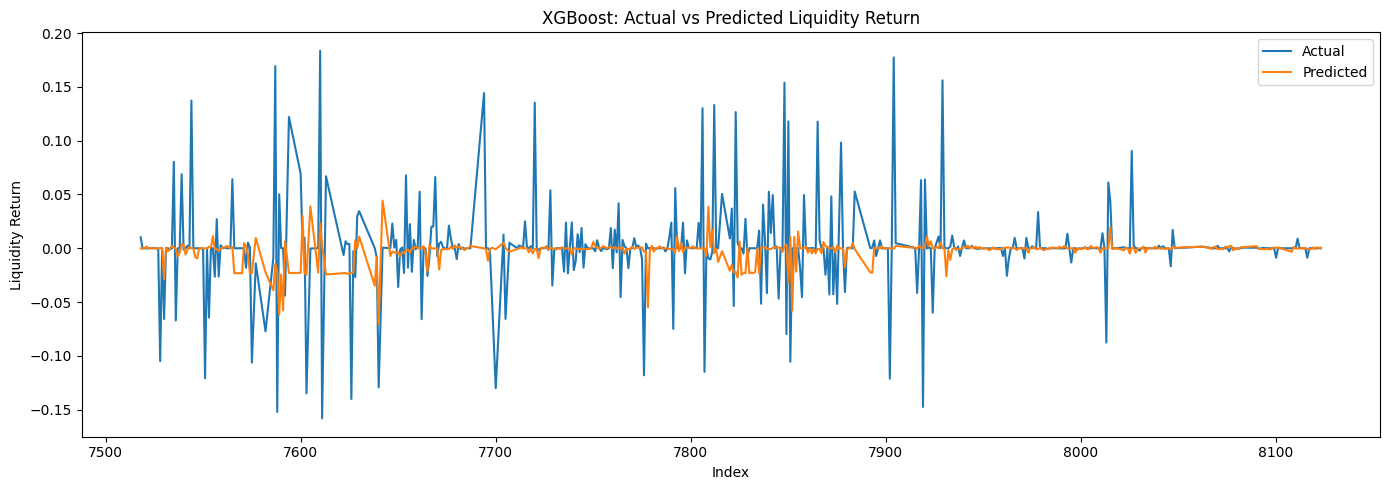

In [69]:
# Plot for XGBoost Model
plot_actual_vs_predicted(y_test[-500:], y_pred[-500:], title="XGBoost: Actual vs Predicted Liquidity Return")